# Assignment 6

## Problem Formulation: ✍
* We need to predict whether the chemical compound that consists from some nodes, and edges to see if they afffect on the cancer activity or not. It is graphical data based problem, and we need to make binary classification.

### Input:
* It is sdf files contain some nodes names like (N, O, C, ...), edges that refers to what is the direction of the links from which node to which node, and the label of the chemical compound that refers whether this compound affects on the cancer activity or not. Part of the data have labels (1, -1) that refer to whether the chemical compound has effect on the cancer activity or not. They are the training dataset. Part of the data have label (0) that don't refer to anything as we are going to predict the right label as they are the test dataset. And here we deal with 3 different inputs after we preprocess the input data files.

### Output:
* We need to make binary classification, to make classification for the test datset to know whether each sample has affect on the cancer activity or not. This is done by training the model on the training data which are graphs, then test the model on the test data which are also graphs.


## What data mining function is required? 🕵🏽
* In this assignment we need "classification and prediction" data mining function.

## What could be the challenges? 😕
* Challenges are: how to deal with a new type of files which are sdf files, how to deal with multi inputs, how to deal with the description of the graphs of the chemical compounds that are written in the sdf file and read it correctly. How to make good preprocessing steps for the text data as we read the nodes as text data. How to deal with the graph data. How to construct a good neural network that is suitable for our dataset and problem. How to make tuning for the number of the vocabulary size, max length for each sentence, and some parameters in the neural network. In addition to how to develop a successful solution for the problem and make good predictions to predict whether the test chemical compound will effect the cancer activity or not. 


## What is the impact? 🤓
* The impact is to know more about the graph data and how to deal with it, make preprocessing for the data, deal with text data, and deal with the neural networks, choose good construction for the layers and tuning their hyperparameters. Besides, know more about how te read a sdf file, and how to convert from the data in the file into text data and visualize it as graphs. So, by constructing a good neural network, this would give the right predictions for the test data to know their activity on the cancer. So, this would be more helpful to know about the new chemical compound, and its activity on the cancer.


## What is an ideal solution? 🦸
* The ideal solution is to make a very good neural network that deals with chemical compounds and graphs that converted into text data. So, by the good network, this will give perfect performance parameters, and this happens after making good preprocessing steps on the text data. So, the model can predict and classify in a right way the activity on the cancer of the new chemical compounds.


## What is the experimental protocol used and how was it carried out? 🤔
* I used the holdout method. So, in the holdout method I give the neural network the size of the validation set so it splits the training dataset into training and validation datasets. So, the network starts in training the model on the training dataset and gets the validation performance and applying the trained model on the validation dataset. So, by this I get the performane on the training and validation to see whether the model started to overfit on the training dataset or not. The performance is given by the AUC value and the loss of the model.


## How did we tune hyper-parameters in the template? 
* The tuning for the hyperparameters like vocabulary size, max length for each sentence, number of epochs, and the batch size by trial and error. Besides, tuning for the number of the units in the layers I used in the neural networks, I used trial and error for them also. As I tried many different numbers for them and get the best one that gives the best result with using the same model without any changes. So, I could choose the one which gives the best results for each of them.


## What is the search space and what is the criteria to determine good/bad hyper-parameters?
* Search space is the space of all feasible, and possible solutions we have to make good hyperparameters tuning. Each point in the search space is one possible solution, and each possible solution can be pointed by its fitness for our problem. As I didn't use a specific tool to search for the best hyperparameters. I used trial and error method to tune the max_length for each sentence, vocabulary size, number of epochs, batch size, and number of the units in the layers I used in the layers of the neural networks. I tried different values for each one on the same model, so the changes only in those hyperparameters, and get the best combination for them that gives the best results on that model.
* The criteria to determine whether the hyperparameters are good or bad is: by monitor the AUC value and the loss between the training and validation, so we can figure out if the model starts to overfit the training dataset or not. Then, compare the resultant auc with the auc that we get from Kaggle, if it is good with the training data, and validation data but it is bad, and gets bad auc on Kaggle from predictions on the unseen dataset "test dataset", so this means the hyperparameters are bad. As they don't give a good results from the unseen dataset.


# Import required libraries

In [1]:
!pip install --quiet networkx

In [2]:
!pip install --quiet tf2_gnn

In [3]:
import os
from google.colab import drive
import numpy as np
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random

# https://github.com/microsoft/tf2-gnn
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
from tf2_gnn.layers.gnn import GNN, GNNInput
import math
import pandas as pd 

import tensorflow as tf
from tensorflow.math import segment_mean
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam
import warnings 
warnings.filterwarnings('ignore')

# Connect to my drive to use the data that I have been uploaded


In [4]:
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/data/DM6')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
def plt_function_op(history):
# split the horizontal area to draw the three plots horizontaly
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
  fig.suptitle('Model Results')
  
  # plot the price accuracy through the training and validation
  ax1.plot(history.history['auc'])
  ax1.plot(history.history['val_auc'])
  ax1.set_title('Model AUC')
  ax1.set_ylabel('AUC value')
  ax1.set_xlabel('Number of epochs')
  ax1.legend(['auc_training', 'auc_validation'], loc='lower right')

  # plot the loss through the training and validation
  ax2.plot(history.history['loss'])
  ax2.plot(history.history['val_loss'])
  ax2.set_title('Model loss')
  ax2.set_ylabel('Loss value')
  ax2.set_xlabel('Number of epochs')
  ax2.legend(['training', 'validation'], loc='upper right')

# Build a function to read the sdf files:
First it read the file, then create 2 empty arrays to be used in saving the links, and the nodes. Wih create a variable with initialization by 0 to save the labels for each compound I have in the file. 

Then I create the labels for each line, if the line ends with 1.0 it saves the label = 1, and if the line ends with -1.0 it saves the label = 0. 

Then in each line, if it starts with tab of spaces, it takes the character after this tab to be the node name, and save it in the array.

Then in eah line, if it starts with 2 spaces, it takes the two number from the file that mean the edge from which node to which node, and save them in the array. As python is zero index, so I need to substract 1 from each number in the edges to be refered to the right node in the nodes array.
 

In [6]:
# read the sdf file by splitting each line after '$$$$', then split the labels as they are the end of each line
# then append the nodes names in their array as they splitted after the tab space
# then append the links between the nodes in their array as they splitted after double space
def read_sdf(file):
    with open(file, 'r') as rf:
        content = rf.read()
        # split by each line
    samples = content.split('$$$$')
    
    def parse_sample(s):
        lines = s.splitlines()
        links = []
        nodes = []
        label = 0
        for l in lines:
            # split and get the labels
            if l.strip() == '1.0':
                label = 1
            if l.strip() == '-1.0':
                label = 0
            if l.startswith('    '):
                # split after the tab space
                feature = l.split()
                node = feature[3]
                nodes.append(node)
            elif l.startswith(' '):
                # split after the double space
                lnk = l.split()
                # edge: (from, to,) (1-based index)
                if int(lnk[0]) - 1 < len(nodes):
                    links.append((
                        int(lnk[0])-1, 
                        int(lnk[1])-1, # zero-based index
                    ))
        return nodes, np.array(links), label
    
    return [parse_sample(s) for s in tqdm(samples) if len(s[0]) > 0]
                
        
        

# Read the training data
Here I will read the sdf file for the training using the above functio. 

Then split the data that returned from the function into two parts: training part, and validation part.

In [7]:
# read the training data sdf file
training_set = read_sdf('train.sdf')
# split it into training and validation parts
training_set_part, validation_set = train_test_split(training_set, test_size=0.15, random_state=42)

  0%|          | 0/25024 [00:00<?, ?it/s]

In [8]:
# read the test data sdf file
testing_set  = read_sdf('test_x.sdf')

  0%|          | 0/12326 [00:00<?, ?it/s]

In [9]:
# check and know more after the samples by viewing one
print(training_set[1])

(['O', 'O', 'O', 'O', 'O', 'O', 'N', 'N', 'N', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C'], array([[ 0,  6],
       [ 0, 15],
       [ 1, 15],
       [ 2,  7],
       [ 3,  8],
       [ 4,  7],
       [ 5,  8],
       [ 6,  9],
       [ 7, 16],
       [ 8, 17],
       [ 9, 10],
       [ 9, 11],
       [10, 12],
       [10, 22],
       [11, 13],
       [11, 23],
       [12, 21],
       [12, 25],
       [13, 20],
       [13, 26],
       [14, 15],
       [14, 18],
       [14, 19],
       [16, 19],
       [16, 24],
       [17, 18],
       [17, 24],
       [20, 21],
       [22, 27],
       [23, 28],
       [25, 29],
       [26, 30],
       [27, 29],
       [28, 30]]), 0)


In [10]:
# get some different colors to be used in the visualization
colors = cm.rainbow(np.linspace(0, 1, 50))

Here a function that is used to visualize the compound according to the nodes and edges I saved from the reading the files of the training and test datasets, which were saved in 2 arrays. 

The visualization is done using changing in the color of the nodes according to the above line where it used the rainbow colors.

This function is looping over the sample that is given, then gets the nodes' names from their array, then plot the lines (edges) according to the number that were saved in the links array which refer to where is the link is going from which node to which node.

In [11]:
# visualize function that is used to visualize any sample is given in its argument
# by moving through the sample's arrays of nodes and links and draw the links by the colors that we used from the rainbow colors above
def visualize(sample):
    G=nx.Graph()
    nodes = sample[0]
    edges = sample[1]
    
    labeldict={}
    node_color=[]
    for i,n in enumerate(nodes):
        G.add_node(i)
        labeldict[i]=n
        node_color.append(colors[hash(n)%len(colors)])

    # a list of nodes:
    for e in edges:
        G.add_edge(e[0], e[1])
        
    nx.draw(G, labels=labeldict, with_labels = True, node_color = node_color)
    plt.show()
    
    return G

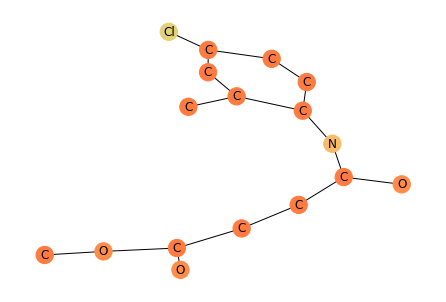

In [12]:
# View one sample from the training data using the visualize function that we defined before.
plt.clf()
visualize(training_set[20])

# Plan for trial 1 
## Preprocessing:
My plan is to use max_vocab = 500 so the model works on the most 500 frequent nodes that appear in the dataset. With using max_len = 30, so the model will work on length = 30, so all samples will be with length = 30. So, if the sample contains less than 30, it will padded with adding zeros untill it reaches length = 30 with padding method = 'post', so zeros will be added after the last element in the sample. If the sample contains more than 30, it will be truncated with the default value = 'pre' so it will remove from the beginning of the sample untill the sample reach length = 30.

Then, as we are dealing with text, I will make tokenization for the input to split it into characters. So, we can fit the tokenization on the input then apply the rest of the steps that we talked about from padding, and truncating. 

Then to deal with our data, we can't split it into batches as we did in the previous assignments. But here we need to generate each batch that the model will work on. I will talk about this part again down.

## Model:
In the model, I will try in this trial the following:

One embedded layer with dimensional space of 20 dimensions that will be applied on our data after victorized it, and in the hidden dimentional in the GNN input layer, I will use 128 unit in it.


## Preprocessing for trial 1:


In [13]:
# define the max_vocab and max_len parameters
max_vocab = 500
max_len = 30


# build vocabulary from training set and make tokenization on the input
all_nodes = [s[0] for s in training_set]
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(all_nodes)

In [14]:
# I will use random.seed(0) to generate each time I run this code the same random numbers if needed
random.seed(0)

# to prepare the samples in each batch 
def prepare_single_batch(samples):
    # get the number of the samples required for each batch
    sample_nodes = [s[0] for s in samples]
    # make victorization for the samples by by turning each text into either a sequence of integers 
    #(each integer being the index of a token in a dictionary) 
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes)
    # prepare the victorized array by making padding by post method
    sample_nodes = pad_sequences(sample_nodes, padding='post')
    # get the number of nodes in each sample
    max_nodes_len = np.shape(sample_nodes)[1]
    # here we need to organize the edges by making the edges in each sample to start from the end of the previous 
    # batch not from zero
    edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)]
    # check that aall edges not zeros
    edges = [e for e in edges if len(e) > 0]
    # convert the graphs of each sample from the sample's nodes by making the graphs in each sample to start from the 
    # end of the previous batch not from zero
    node_to_graph = [[i]*max_nodes_len for i in range(len(samples))]
    # convert the shape of the sample nodes into array by making each sample's sample_nodes into columns in one row, 
    # and the rows refer to the samples
    all_nodes = np.reshape(sample_nodes, -1)
    # make concatenation for the arrays of edgesin all samples in the batch
    all_edges = np.concatenate(edges)
    
    # reshape the node_to_graph to array by making each sample's node_to_graph into columns in one row, and the rows refer to 
    # the samples
    node_to_graph = np.reshape(node_to_graph, -1)
    return {
        'data': all_nodes,
        'edges': all_edges,
        'node2grah': node_to_graph,
    }, np.array([s[2] for s in samples])



# function to geerate the batches required by splitting the given data into batches and each batch is prepared by the 
# prepare_single_batch function
def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True):
    while True:
        dataset = list(dataset)
        if shuffle:
            random.shuffle(dataset)
        l = len(dataset)
        for ndx in range(0, l, batch_size):
            batch_samples = dataset[ndx:min(ndx + batch_size, l)]
            yield prepare_single_batch(batch_samples)
        if not repeat:
            break


In [15]:
# showing one batch after finishing the preprocessing to see the difference
for train_batch in gen_batch(training_set, batch_size=4):
    for k,v in train_batch[0].items():
        print(k)
        print(v)
        pass
    print('label', train_batch[1])
    break

data
[2 2 2 2 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 2 2 2
 2 2 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 5 4 2 2 3 3
 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 6 6 2 2 3 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
edges
[[  0   9]
 [  0  20]
 [  1  19]
 [  1  25]
 [  2  19]
 [  3  20]
 [  4   6]
 [  4   9]
 [  5   8]
 [  5  10]
 [  6   7]
 [  6  11]
 [  7   8]
 [  7  12]
 [  8  13]
 [  9  10]
 [ 10  14]
 [ 11  15]
 [ 11  16]
 [ 12  17]
 [ 13  18]
 [ 14  19]
 [ 15  21]
 [ 16  22]
 [ 17  18]
 [ 20  24]
 [ 21  23]
 [ 22  23]
 [ 25  26]
 [ 34  43]
 [ 34  45]
 [ 35  39]
 [ 36  39]
 [ 37  56]
 [ 38  57]
 [ 39  44]
 [ 40  57]
 [ 40  62]
 [ 41  56]
 [ 41  63]
 [ 42  43]
 [ 42  44]
 [ 42  47]
 [ 43  46]
 [ 44  49]
 [ 45  48]
 [ 45  51]
 [ 46  48]
 [ 47  50]
 [ 49  52]
 [ 50  52]
 [ 51  55]
 [ 53  56]
 [ 53  58]
 [ 53  59]
 [ 54  60]
 [ 54  61]
 [ 54  62]
 [ 55  57]
 [ 58  60]
 [ 59  61]
 [ 63  64]
 [ 64  65]
 [ 65  66]
 [ 65  6

## Model for trial 1

In [16]:
# prepare input units for each input we have for the neural network
data = keras.Input(batch_shape=(None,))
# the first dim is different to the previous one, it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
# insert the embedding layer with embedding space of 20 dimensions that will be applied on our data after victorized it
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples), and add 1 as python is zero based 
num_graph = tf.reduce_max(node2graph)+1

# prepare the Graph Neural Network input layer by give it its inputs
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# get the parameters that are required to be used with the Graph Neural Network input layer so we can get the output
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
# change the number of the size of the output of all message passing layers to 128 layer
params["hidden_dim"] = 128
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

# get the mean of each sample in each batch by using the segment_mean as each sample is a segment in the array
# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

# prepare the output node for our problem with 1 unit which gives 0 or 1 as we are making binary classification
pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)

# define our model and give it the inputs layers and the outputs layers
model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
# view the model with its parameters and shapes of the layers
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None,)]            0           []                    

In [17]:
# compile the model with BinaryCrossentropy loss as we are making binary classification, and AUC metric
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [18]:
# define the size of the batch
batch_size = 128
# get the number of the batches in the training and validation by splitting the size of the training data or validation data
# by the size required for the batch
num_batchs = math.ceil(len(training_set_part) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

# fit the model on the training data and validation data by generating the bathes for the training and validation
history = model.fit(
    gen_batch(
        training_set_part, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=40,
    validation_data=gen_batch(
        validation_set, batch_size=128, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/40
167/167 [==============================] - 18s 46ms/step - loss: 0.2618 - auc: 0.4477 - val_loss: 0.2341 - val_auc: 0.5379
Epoch 2/40
167/167 [==============================] - 7s 43ms/step - loss: 0.1998 - auc: 0.5847 - val_loss: 0.1978 - val_auc: 0.6724
Epoch 3/40
167/167 [==============================] - 7s 43ms/step - loss: 0.1914 - auc: 0.6300 - val_loss: 0.2325 - val_auc: 0.6554
Epoch 4/40
167/167 [==============================] - 7s 44ms/step - loss: 0.1888 - auc: 0.6391 - val_loss: 0.1780 - val_auc: 0.7161
Epoch 5/40
167/167 [==============================] - 7s 43ms/step - loss: 0.1861 - auc: 0.6537 - val_loss: 0.2290 - val_auc: 0.5964
Epoch 6/40
167/167 [==============================] - 7s 44ms/step - loss: 0.1857 - auc: 0.6659 - val_loss: 0.1819 - val_auc: 0.7159
Epoch 7/40
167/167 [==============================] - 7s 43ms/step - loss: 0.1840 - auc: 0.6742 - val_loss: 0.2172 - val_auc: 0.7116
Epoch 8/40
167/167 [==============================] - 7s 43ms/step -

In [19]:
# predict the outputs also by generating the batch by the given size
y_pred = model.predict(
    gen_batch(testing_set, batch_size=128, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

In [20]:
# save the predictions in a csv file to submit it on Kaggle
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('try 1.csv')

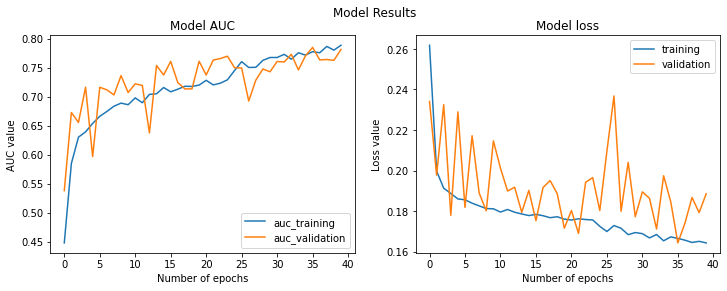

In [21]:
plt_function_op(history)

## Thoughts and observation for trial 1:
This gave a score on Kaggle = 0.79675.

I didn't think that this model will be suitable, and give a good results, and that what happened. As I didn't tune the hyper-parameters, Besides, the number of the units in the embedding layer were small. I tried to control the overfitting on the training data by validate the model. I used a batch size not small and this helps also in preventing the overfitting.
So, by training the model I reached auc on the validation set = 0.7812, and the resultant auc on Kaggel is 0.79675. So, this means they are close to each other, and there is small overfitting. Besides, from the above graphs we can see that there is small overfitting but the results are not good enough as the loss in the validation increased but in the training decreased. And from the graphs we can see that there are many big oscillations which means the model is not good on the unseen datasets.


## Plan for the trial 2:
I will continue with the same preprocessing way. But I will make some changes in the model. By applying an aggregation method = 'RGCN' in the parameters of the GNN input layer. 

Which helps in solving those two fundamental tasks: Entity classification - Where you assign types and categorical properties to entities, and Link prediction - Where you recover missing triples.
AS it is using a common graph convolutional network. It’s extended with multi-edge encoding to compute embedding of the entities, but with different downstream processing. So, Entity classification is done by attaching a softmax classifier at the final embedding of an entity (node). Training is through loss of standard cross-entropy, and Link prediction is done by reconstructing an edge with an autoencoder architecture, using a parameterized score function. Training uses negative sampling.

# Trial 2 
With aggregation method:

RGCN : Relational Graph Convolutional Networks

## Model for trial2:

In [22]:
# prepare input units for each input we have for the neural network
data = keras.Input(batch_shape=(None,))
# the first dim is different to the previous one, it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
# insert the embedding layer with embedding space of 20 dimensions that will be applied on our data after victorized it
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples), and add 1 as python is zero based 
num_graph = tf.reduce_max(node2graph)+1

# prepare the Graph Neural Network input layer by give it its inputs
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# get the parameters that are required to be used with the Graph Neural Network input layer so we can get the output
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
# change the number of the size of the output of all message passing layers to 128 layer
params["hidden_dim"] = 128
# add the parameter of the aggregation method
params["message_calculation_class"] = "RGCN"
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

# get the mean of each sample in each batch by using the segment_mean as each sample is a segment in the array
# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

# prepare the output node for our problem with 1 unit which gives 0 or 1 as we are making binary classification
pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)

# define our model and give it the inputs layers and the outputs layers
model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
# view the model with its parameters and shapes of the layers
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='gnn_1/StatefulPartitionedCall:0', description="created by layer 'gnn_1'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='tf.math.segment_mean_1/SegmentMean:0', description="created by layer 'tf.math.segment_mean_1'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_1/Sigmoid:0', description="created by layer 'dense_1'")
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None,)]            0           []      

In [23]:
# compile the model with BinaryCrossentropy loss as we are making binary classification, and AUC metric
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [24]:
# define the size of the batch
batch_size = 128
# get the number of the batches in the training and validation by splitting the size of the training data or validation data
# by the size required for the batch
num_batchs = math.ceil(len(training_set_part) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

# fit the model on the training data and validation data by generating the bathes for the training and validation
history = model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=40,
    validation_data=gen_batch(
        validation_set, batch_size=128, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/40
167/167 [==============================] - 11s 47ms/step - loss: 0.2533 - auc: 0.4729 - val_loss: 0.1907 - val_auc: 0.6649
Epoch 2/40
167/167 [==============================] - 8s 45ms/step - loss: 0.1994 - auc: 0.5789 - val_loss: 0.1948 - val_auc: 0.7053
Epoch 3/40
167/167 [==============================] - 7s 43ms/step - loss: 0.1931 - auc: 0.6438 - val_loss: 0.1827 - val_auc: 0.7177
Epoch 4/40
167/167 [==============================] - 7s 43ms/step - loss: 0.1896 - auc: 0.6381 - val_loss: 0.1831 - val_auc: 0.7287
Epoch 5/40
167/167 [==============================] - 7s 42ms/step - loss: 0.1840 - auc: 0.6756 - val_loss: 0.1866 - val_auc: 0.7391
Epoch 6/40
167/167 [==============================] - 7s 43ms/step - loss: 0.1888 - auc: 0.6721 - val_loss: 0.1780 - val_auc: 0.7376
Epoch 7/40
167/167 [==============================] - 7s 43ms/step - loss: 0.1803 - auc: 0.6879 - val_loss: 0.1740 - val_auc: 0.7731
Epoch 8/40
167/167 [==============================] - 7s 43ms/step -

In [25]:
# predict the outputs also by generating the batch by the given size
y_pred = model.predict(
    gen_batch(testing_set, batch_size=128, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

In [26]:
# save the predictions in a csv file to submit it on Kaggle
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('try 2.csv')

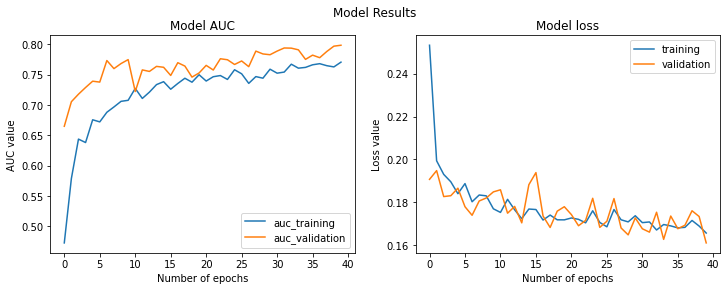

In [27]:
plt_function_op(history)

## Thoughts and observation for trial 2:
This gave a score on Kaggle = 0.78811.

I thought that this model will be suitable, and give a better results, but that didn't happen. But it gave a better results than in the trial 1. As I tried a different parameter in the message_calculation_class which is "RGCN", and I thought this way will make the model more efficient. I tried to control the overfitting on the training data by validate the model. I used a batch size not small and this helps also in preventing the overfitting.
So, by training the model I reached auc on the validation set = 0.7982, and the resultant auc on Kaggel is 0.78811. So, this means they are close to each other, and there is no overfitting or underfitting in the model. Besides, from the above graphs we can see that there is no overfitting, and the results are good. And the oscillations decreased in their amplitudes.


## Plan for the trial 3:
I will continue with the same preprocessing way. But I will make some changes in the model. By applying an aggregation method = 'GGNN' in the parameters of the GNN input layer. 

Which helps in unrolling recurrence for a fixed number of steps and just use backpropagation through time with modern  optimization methods.It changed also the propagation model a bit to use gating mechanisms like in LSTMs and GRUs. So, now the learning to compute representations within a fixed budget, and the gating makes the propagation model better. 

# Trial 3
With aggregation method: 

GGNN: Gated Graph Neural Networks 


## Model for trial 3

In [28]:
# prepare input units for each input we have for the neural network
data = keras.Input(batch_shape=(None,))
# the first dim is different to the previous one, it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
# insert the embedding layer with embedding space of 20 dimensions that will be applied on our data after victorized it
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples), and add 1 as python is zero based 
num_graph = tf.reduce_max(node2graph)+1

# prepare the Graph Neural Network input layer by give it its inputs
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# get the parameters that are required to be used with the Graph Neural Network input layer so we can get the output
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 128
# define the message_calculation_class parameter to GGNN
params["message_calculation_class"] = "GGNN"
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

# get the mean of each sample in each batch by using the segment_mean as each sample is a segment in the array
# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

# prepare the output node for our problem with 1 unit which gives 0 or 1 as we are making binary classification
pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)

# define our model and give it the inputs layers and the outputs layers
model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
# view the model with its parameters and shapes of the layers
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='gnn_2/StatefulPartitionedCall:0', description="created by layer 'gnn_2'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='tf.math.segment_mean_2/SegmentMean:0', description="created by layer 'tf.math.segment_mean_2'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_2/Sigmoid:0', description="created by layer 'dense_2'")
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None,)]            0           []      

In [29]:
# compile the model with BinaryCrossentropy loss as we are making binary classification, and AUC metric
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [30]:
# define the size of the batch
batch_size = 128
# get the number of the batches in the training and validation by splitting the size of the training data or validation data
# by the size required for the batch
num_batchs = math.ceil(len(training_set_part) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

# fit the model on the training data and validation data by generating the bathes for the training and validation
history = model.fit(
    gen_batch(
        training_set_part, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=40,
    validation_data=gen_batch(
        validation_set, batch_size=128, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/40
167/167 [==============================] - 19s 92ms/step - loss: 0.2049 - auc: 0.5748 - val_loss: 0.2247 - val_auc: 0.6860
Epoch 2/40
167/167 [==============================] - 15s 89ms/step - loss: 0.1871 - auc: 0.6467 - val_loss: 0.2195 - val_auc: 0.7369
Epoch 3/40
167/167 [==============================] - 15s 89ms/step - loss: 0.1824 - auc: 0.6882 - val_loss: 0.1847 - val_auc: 0.7630
Epoch 4/40
167/167 [==============================] - 15s 90ms/step - loss: 0.1759 - auc: 0.7225 - val_loss: 0.2032 - val_auc: 0.7452
Epoch 5/40
167/167 [==============================] - 15s 88ms/step - loss: 0.1743 - auc: 0.7286 - val_loss: 0.1816 - val_auc: 0.7664
Epoch 6/40
167/167 [==============================] - 15s 90ms/step - loss: 0.1725 - auc: 0.7438 - val_loss: 0.1723 - val_auc: 0.7814
Epoch 7/40
167/167 [==============================] - 15s 89ms/step - loss: 0.1713 - auc: 0.7423 - val_loss: 0.1796 - val_auc: 0.7206
Epoch 8/40
167/167 [==============================] - 15s 88ms

In [31]:
# predict the outputs also by generating the batch by the given size
y_pred = model.predict(
    gen_batch(testing_set, batch_size=128, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

In [32]:
# save the predictions in a csv file to submit it on Kaggle
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('try 3.csv')

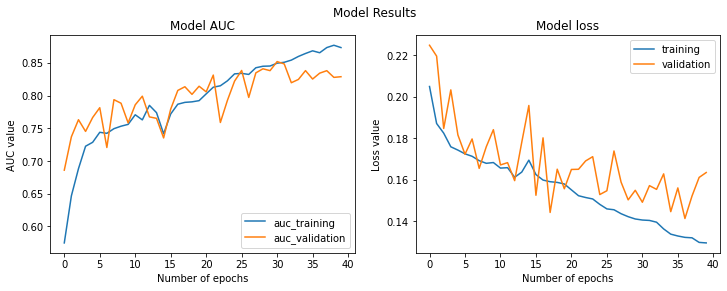

In [33]:
plt_function_op(history)

## Thoughts and observation for trial 3:
This gave a score on Kaggle = 0.84201.

I thought that this model will give a very good results, and that what happened. As the algorithm that I used in the model which is the Gated Graph Neural Networks, I thought will work well on the data due to its mechanism which I talked about before. Although the number of the units in the embedding layer were small but the results are good. I tried to control the overfitting on the training data by validate the model. I used a batch size not small and this helps also in preventing the overfitting.
So, by training the model I reached auc on the validation set = 0.8288, and the resultant auc on Kaggel is 0.84201. So, this means they are close to each other, but I think the model started to overfit the training data as the auc value started to decrease after the epoch number 35, and the loss increased after the same epoch number. In the above graphs, we can see the difference after the epoch 35, and the oscillications increased in their amplitudes again.


## Plan for the trial 4:
I will continue with the same preprocessing way. But I will make some changes in the model. By applying an aggregation method = 'RGAT' in the parameters of the GNN input layer. 

Which helps in solving the problem of focusing on modelling simple undirected and single relational graph data only that is happened by Graph Attention Network (GAT). So, this limits its ability to deal with more general and complex multi-relational graphs that contain entities with directed links of different labels. Therefore, directly applying GAT on multi-relational graphs leads to sub-optimal solutions. So, using RGAT helps to learn multi-channel entity representations. Specifically, each channel corresponds to a latent semantic aspect of an entity. This enables to aggregate neighborhood information for the current aspect using relation features. Therefore, we propose a query-aware attention mechanism for subsequent tasks to select useful aspects. Extensive experiments on link prediction and entity classification tasks show that our r-GAT can model multi-relational graphs effectively.

# Trial 4
With aggregation method:

RGAT: Relational Graph Attention Networks

In [34]:
# prepare input units for each input we have for the neural network
data = keras.Input(batch_shape=(None,))
# the first dim is different to the previous one, it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
# insert the embedding layer with embedding space of 20 dimensions that will be applied on our data after victorized it
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples), and add 1 as python is zero based 
num_graph = tf.reduce_max(node2graph)+1

# prepare the Graph Neural Network input layer by give it its inputs
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# get the parameters that are required to be used with the Graph Neural Network input layer so we can get the output
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
# change the number of the size of the output of all message passing layers to 128 layer
params["hidden_dim"] = 128
# define the aggregation method
params["message_calculation_class"] = "RGAT"
# define the num_heads whih configures the number of parallel (independent) weighted sums that are computed, 
# whose results are concatenated to obtain the final result.
params["num_heads"] = 4
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

# get the mean of each sample in each batch by using the segment_mean as each sample is a segment in the array
# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

# prepare the output node for our problem with 1 unit which gives 0 or 1 as we are making binary classification
pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)

# define our model and give it the inputs layers and the outputs layers
model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
# view the model with its parameters and shapes of the layers
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='gnn_3/StatefulPartitionedCall:0', description="created by layer 'gnn_3'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='tf.math.segment_mean_3/SegmentMean:0', description="created by layer 'tf.math.segment_mean_3'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_3/Sigmoid:0', description="created by layer 'dense_3'")
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None,)]            0           []      

In [35]:
# compile the model with BinaryCrossentropy loss as we are making binary classification, and AUC metric
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [36]:
# define the size of the batch
batch_size = 128
# get the number of the batches in the training and validation by splitting the size of the training data or validation data
# by the size required for the batch
num_batchs = math.ceil(len(training_set_part) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

# fit the model on the training data and validation data by generating the bathes for the training and validation
history = model.fit(
    gen_batch(
        training_set_part, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=40,
    validation_data=gen_batch(
        validation_set, batch_size=128, repeat=True
    ),
    validation_steps=num_batchs_validation,
)


Epoch 1/40
167/167 [==============================] - 16s 67ms/step - loss: 0.2652 - auc: 0.4768 - val_loss: 0.2812 - val_auc: 0.6919
Epoch 2/40
167/167 [==============================] - 11s 63ms/step - loss: 0.2000 - auc: 0.5910 - val_loss: 0.1980 - val_auc: 0.7198
Epoch 3/40
167/167 [==============================] - 11s 64ms/step - loss: 0.1913 - auc: 0.6356 - val_loss: 0.1840 - val_auc: 0.7235
Epoch 4/40
167/167 [==============================] - 11s 64ms/step - loss: 0.1852 - auc: 0.6669 - val_loss: 0.2178 - val_auc: 0.7263
Epoch 5/40
167/167 [==============================] - 11s 64ms/step - loss: 0.1834 - auc: 0.6749 - val_loss: 0.1797 - val_auc: 0.7525
Epoch 6/40
167/167 [==============================] - 11s 64ms/step - loss: 0.1807 - auc: 0.6990 - val_loss: 0.1722 - val_auc: 0.7647
Epoch 7/40
167/167 [==============================] - 11s 64ms/step - loss: 0.1779 - auc: 0.7134 - val_loss: 0.2120 - val_auc: 0.7022
Epoch 8/40
167/167 [==============================] - 11s 64ms

In [37]:
# predict the outputs also by generating the batch by the given size
y_pred = model.predict(
    gen_batch(testing_set, batch_size=128, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

In [38]:
# save the predictions in a csv file to submit it on Kaggle
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('try 4.csv')

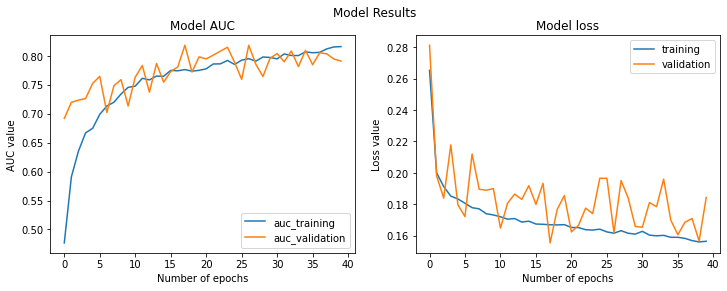

In [39]:
plt_function_op(history)

## Thoughts and observation for trial 4:
This gave a score on Kaggle = 0.82537.

I thought that this model will give a very good results, and that what happened. As the algorithm that I used in the model which is the Relational Graph Attention Networks, I thought will work well on the data due to its mechanism which I talked about before. Although the number of the units in the embedding layer were small but the results are good. I tried to control the overfitting on the training data by validate the model. I used a batch size not small and this helps also in preventing the overfitting.
So, by training the model I reached auc on the validation set = 0.7910, and the resultant auc on Kaggel is 0.82537. So, this means they are close to each other, and there is no overfitting or underfitting in the model. Besides, from the above graphs we can see that there is no overfitting and the results are good. As the oscillations decreased a little bit. 


## Plan for the trial 5:
I will change the preprocessing way, and change some things in the model. First in the preprocessing, I found that the data is unbalanced, so I will make upsampling for it by increasing the amount of the data that related to class 1 as they are very few in comparing with the data related to class 0.
In the model, I will use the following:
One embedded layer with dimensional space of 30 dimensions that will be applied on our data after victorized it, and in the hidden dimentional in the GNN input layer, I will use 256 unit in it.


# Trial 5
## Preprocessing:
### Upsampling for the weights of each class 


In [40]:
np.unique(np.array(training_set)[:,2],return_counts=True)

(array([0, 1], dtype=object), array([23806,  1218]))

From the above results we can see that there is unbalance in the weights between the two classes, and we need to make upsampling for the class 1 as it has a very small number in compare with the class 0. As class 0 has 23806, and class 1 has 1218.

In [41]:
# get features from the training set
x = np.array(training_set)[:,0:2]
# get the labels
y = np.array(training_set)[:,2]

In [42]:
# extract each class according to its label
data_class0 = x[y == 0]
data_class1 = x[y == 1]

In [43]:
# make resmapling for the class with the lower quantity
from sklearn.utils import resample
data_class1_upsample = resample(data_class1 ,
             replace=True,
             n_samples=len(data_class0),
             random_state=42)

print(len(class1_upsample))

23806


In [44]:
# create array of zeros to be used to label the data that has zero labels and stack the columns together
label_0 = np.zeros(len(data_class0)).astype(int)
data_class0 = np.column_stack([data_class0,label_0])

In [45]:
# create array of ones to be used to label the data that need to have one labels after upsampling it and stack the 
# columns together
label_1 = np.ones(len(data_class1_upsample)).astype(int)
data_class1_upsample = np.column_stack([data_class1_upsample,label_1])

In [46]:
# concatinate the two parts 
data_upsampled = np.concatenate([data_class0, data_class1_upsample])

In [47]:
np.unique(np.array(data_upsampled)[:,2],return_counts=True)

(array([0, 1], dtype=object), array([23806, 23806]))

In [48]:
# split the upsampled data into training and validation
training_set_up, validation_set_up = train_test_split(data_upsampled, test_size=0.15,)

In [49]:
# prepare input units for each input we have for the neural network
data = keras.Input(batch_shape=(None,))
# the first dim is different to the previous one, it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
# insert the embedding layer with embedding space of 30 dimensions that will be applied on our data after victorized it
embeded = Embedding(tokenizer.num_words, 30)(data)

# number of graphs (number of samples), and add 1 as python is zero based 
num_graph = tf.reduce_max(node2graph)+1

# prepare the Graph Neural Network input layer by give it its inputs
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# get the parameters that are required to be used with the Graph Neural Network input layer so we can get the output
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
# change the number of the size of the output of all message passing layers to 256 layer
params["hidden_dim"] = 256
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

# get the mean of each sample in each batch by using the segment_mean as each sample is a segment in the array
# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

# prepare the output node for our problem with 1 unit which gives 0 or 1 as we are making binary classification
pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)

# define our model and give it the inputs layers and the outputs layers
model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
# view the model with its parameters and shapes of the layers
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 256), dtype=tf.float32, name=None), name='gnn_4/StatefulPartitionedCall:0', description="created by layer 'gnn_4'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 256), dtype=tf.float32, name=None), name='tf.math.segment_mean_4/SegmentMean:0', description="created by layer 'tf.math.segment_mean_4'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_4/Sigmoid:0', description="created by layer 'dense_4'")
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_13 (InputLayer)          [(None,)]            0           []      

In [50]:
# compile the model with BinaryCrossentropy loss as we are making binary classification, and AUC metric
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [51]:
# define the size of the batch
batch_size = 128
# get the number of the batches in the training and validation by splitting the size of the training data or validation data
# by the size required for the batch
num_batchs = math.ceil(len(training_set_up) / batch_size)
num_batchs_validation = math.ceil(len(validation_set_up) / batch_size)

# fit the model on the training data and validation data by generating the bathes for the training and validation
history = model.fit(
    gen_batch(
        training_set_up, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=40,
    validation_data=gen_batch(
        validation_set_up, batch_size=128, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/40
317/317 [==============================] - 30s 86ms/step - loss: 0.6297 - auc: 0.7022 - val_loss: 0.6028 - val_auc: 0.7348
Epoch 2/40
317/317 [==============================] - 27s 84ms/step - loss: 0.5906 - auc: 0.7534 - val_loss: 0.6000 - val_auc: 0.7642
Epoch 3/40
317/317 [==============================] - 27s 84ms/step - loss: 0.5715 - auc: 0.7749 - val_loss: 0.6143 - val_auc: 0.7717
Epoch 4/40
317/317 [==============================] - 27s 83ms/step - loss: 0.5532 - auc: 0.7938 - val_loss: 0.5490 - val_auc: 0.8049
Epoch 5/40
317/317 [==============================] - 27s 84ms/step - loss: 0.5379 - auc: 0.8083 - val_loss: 0.5232 - val_auc: 0.8247
Epoch 6/40
317/317 [==============================] - 27s 84ms/step - loss: 0.5189 - auc: 0.8242 - val_loss: 0.5215 - val_auc: 0.8226
Epoch 7/40
317/317 [==============================] - 27s 84ms/step - loss: 0.5014 - auc: 0.8369 - val_loss: 0.5308 - val_auc: 0.8280
Epoch 8/40
317/317 [==============================] - 27s 84ms

In [52]:
# predict the outputs also by generating the batch by the given size
y_pred = model.predict(
    gen_batch(testing_set, batch_size=128, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

In [53]:
# save the predictions in a csv file to submit it on Kaggle
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('try 5.csv')

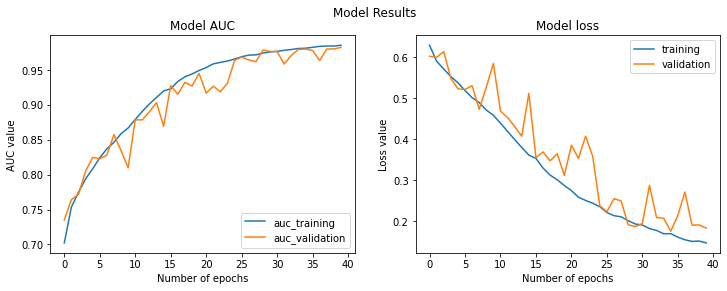

In [54]:
plt_function_op(history)

## Thoughts and observation for trial 5:
This gave a score on Kaggle = 0.82407.

I thought this trial will be very good as now I made the balanced and each class has the same weight in the contribution in the model. Although the number of the units in the embedding layer were small, the results are good in comparing it with the results I got in trial 1 before upsampling the data. I tried to control the overfitting on the training data by validate the model. I used a batch size not small and this helps also in preventing the overfitting.
So, by training the model I reached auc on the validation set = 0.9822, and the resultant auc on Kaggel is 0.82407. So, I think the model is learned well from the input features as the validation result is very good. Besides, from the above graphs we can see that there is no overfitting or underfitting, and the results are good enough. So, the upsampling for the data has a good effect on the results. And the oscillations are decreased a lot. I think with aggregation methods would be better more.


## Plan for the trial 6:
I will continue with the same preprocessing way with the upsampled data. But I will make some changes in the model. By applying an aggregation method = 'GGNN' in the parameters of the GNN input layer. 

Which helps in unrolling recurrence for a fixed number of steps and just use backpropagation through time with modern  optimization methods.It changed also the propagation model a bit to use gating mechanisms like in LSTMs and GRUs. So, now the learning to compute representations within a fixed budget, and the gating makes the propagation model better. 
And I will apply the model on the upsampling data. With one embedded layer with dimensional space of 700 dimensions that will be applied on our data after victorized it, and in the hidden dimentional in the GNN input layer, I will use 128 unit in it.

# Trial 6
With upsampling + aggregation method =  "GGNN" + 700 dimensional space in embedded layer, and 128 unit in the hidden dimentional in the GNN input layer.


In [55]:
# prepare input units for each input we have for the neural network
data = keras.Input(batch_shape=(None,))
# the first dim is different to the previous one, it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
# insert the embedding layer with embedding space of 700 dimensions that will be applied on our data after victorized it
embeded = Embedding(tokenizer.num_words, 700)(data)

# number of graphs (number of samples), and add 1 as python is zero based 
num_graph = tf.reduce_max(node2graph)+1

# prepare the Graph Neural Network input layer by give it its inputs
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# get the parameters that are required to be used with the Graph Neural Network input layer so we can get the output
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
# change the number of the size of the output of all message passing layers to 128 layer
params["hidden_dim"] = 128
# define the aggregation method
params["message_calculation_class"] = "GGNN"
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

# get the mean of each sample in each batch by using the segment_mean as each sample is a segment in the array
# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

# prepare the output node for our problem with 1 unit which gives 0 or 1 as we are making binary classification
pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)

# define our model and give it the inputs layers and the outputs layers
model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
# view the model with its parameters and shapes of the layers
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='gnn_5/StatefulPartitionedCall:0', description="created by layer 'gnn_5'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='tf.math.segment_mean_5/SegmentMean:0', description="created by layer 'tf.math.segment_mean_5'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_5/Sigmoid:0', description="created by layer 'dense_5'")
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_16 (InputLayer)          [(None,)]            0           []      

In [56]:
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [57]:
# define the size of the batch
batch_size = 64
# get the number of the batches in the training and validation by splitting the size of the training data or validation data
# by the size required for the batch
num_batchs = math.ceil(len(training_set_up) / batch_size)
num_batchs_validation = math.ceil(len(validation_set_up) / batch_size)

# fit the model on the training data and validation data by generating the bathes for the training and validation
history = model.fit(
    gen_batch(
        training_set_up, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=40,
    validation_data=gen_batch(
        validation_set_up, batch_size=64, repeat=True
    ),
    validation_steps=num_batchs_validation,
)


Epoch 1/40
633/633 [==============================] - 41s 58ms/step - loss: 0.6010 - auc: 0.7392 - val_loss: 0.5405 - val_auc: 0.8136
Epoch 2/40
633/633 [==============================] - 36s 57ms/step - loss: 0.5259 - auc: 0.8158 - val_loss: 0.4905 - val_auc: 0.8490
Epoch 3/40
633/633 [==============================] - 36s 57ms/step - loss: 0.4589 - auc: 0.8656 - val_loss: 0.4218 - val_auc: 0.8908
Epoch 4/40
633/633 [==============================] - 36s 57ms/step - loss: 0.4134 - auc: 0.8930 - val_loss: 0.3855 - val_auc: 0.9088
Epoch 5/40
633/633 [==============================] - 36s 57ms/step - loss: 0.3681 - auc: 0.9161 - val_loss: 0.3658 - val_auc: 0.9206
Epoch 6/40
633/633 [==============================] - 36s 57ms/step - loss: 0.3316 - auc: 0.9317 - val_loss: 0.3166 - val_auc: 0.9421
Epoch 7/40
633/633 [==============================] - 36s 57ms/step - loss: 0.2979 - auc: 0.9447 - val_loss: 0.2916 - val_auc: 0.9477
Epoch 8/40
633/633 [==============================] - 36s 57ms

In [58]:
# predict the outputs also by generating the batch by the given size
y_pred = model.predict(
    gen_batch(testing_set, batch_size=64, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

In [59]:
# save the predictions in a csv file to submit it on Kaggle
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('try 6.csv')

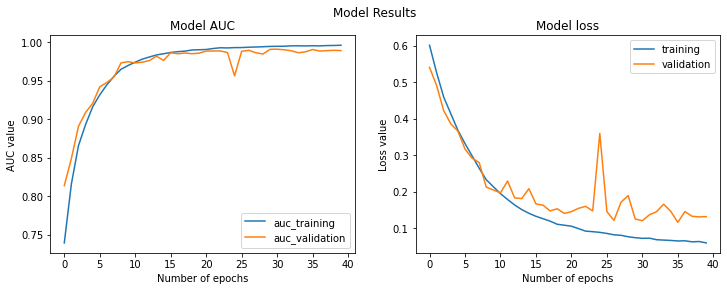

In [60]:
plt_function_op(history)

## Thoughts and observation for trial 6:
This gave a score on Kaggle = 0.84245.

I thought this trial will be perfect as now I made the balanced and each class has the same weight in the contribution in the model. Besides, I used the aggregation method =  GGNN, which gave me a very good results before the upsampling. I increased the number of the units in the embedding layer, so all of this I thought the results will be good and the model will learn well from the features. I tried to control the overfitting on the training data by validate the model. I used a batch size not small and this helps also in preventing the overfitting.
So, by training the model I reached auc on the validation set = 0.9892, and the resultant auc on Kaggel is 0.84245. So, this means there is no overfitting or underfitting in the model. Besides, from the above graphs we can see that there is no overfitting but the results are good enough. So, the upsampling for the data has a very good effect on the results with the using of the aggregation method = GGNN. Besides, increasing the number of the units in the embedding layer helped the model. But we can see from the graph the model didn't work well on the validation data from epoch 20 to 25, but then it returned to be good.


## Plan for the trial 7:
I will continue with the same preprocessing way on the upsampling data. But I will make some changes in the model. By applying an aggregation method = 'RGAT' in the parameters of the GNN input layer. 

Which helps in solving the problem of focusing on modelling simple undirected and single relational graph data only that is happened by Graph Attention Network (GAT). So, this limits its ability to deal with more general and complex multi-relational graphs that contain entities with directed links of different labels. Therefore, directly applying GAT on multi-relational graphs leads to sub-optimal solutions. So, using RGAT helps to learn multi-channel entity representations. Specifically, each channel corresponds to a latent semantic aspect of an entity. This enables to aggregate neighborhood information for the current aspect using relation features. Therefore, we propose a query-aware attention mechanism for subsequent tasks to select useful aspects. Extensive experiments on link prediction and entity classification tasks show that our r-GAT can model multi-relational graphs effectively.

So, I can see the effect of the upsampling data with the RGAT aggregation method.

# Trial 7
With upsampling data + RGAT aggregation method + 500 dimensional space in embedded layer, and 128 unit in the hidden dimentional in the GNN input layer.

In [61]:
# prepare input units for each input we have for the neural network
data = keras.Input(batch_shape=(None,))
# the first dim is different to the previous one, it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
# insert the embedding layer with embedding space of 500 dimensions that will be applied on our data after victorized it
embeded = Embedding(tokenizer.num_words, 500)(data)

# number of graphs (number of samples), and add 1 as python is zero based 
num_graph = tf.reduce_max(node2graph)+1

# prepare the Graph Neural Network input layer by give it its inputs
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# get the parameters that are required to be used with the Graph Neural Network input layer so we can get the output
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
# change the number of the size of the output of all message passing layers to 128 layer
params["hidden_dim"] = 128
# define the aggregation method
params["message_calculation_class"] = "RGAT"
# define the num_heads whih configures the number of parallel (independent) weighted sums that are computed, 
# whose results are concatenated to obtain the final result.
params["num_heads"] = 4
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

# get the mean of each sample in each batch by using the segment_mean as each sample is a segment in the array
# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

# prepare the output node for our problem with 1 unit which gives 0 or 1 as we are making binary classification
pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)

# define our model and give it the inputs layers and the outputs layers
model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
# view the model with its parameters and shapes of the layers
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='gnn_6/StatefulPartitionedCall:0', description="created by layer 'gnn_6'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='tf.math.segment_mean_6/SegmentMean:0', description="created by layer 'tf.math.segment_mean_6'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_6/Sigmoid:0', description="created by layer 'dense_6'")
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_19 (InputLayer)          [(None,)]            0           []      

In [62]:
# compile the model with BinaryCrossentropy loss as we are making binary classification, and AUC metric
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [63]:
# define the size of the batch
batch_size = 128
# get the number of the batches in the training and validation by splitting the size of the training data or validation data
# by the size required for the batch
num_batchs = math.ceil(len(training_set_up) / batch_size)
num_batchs_validation = math.ceil(len(validation_set_up) / batch_size)

# fit the model on the training data and validation data by generating the bathes for the training and validation
history = model.fit(
    gen_batch(
        training_set_up, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=40,
    validation_data=gen_batch(
        validation_set_up, batch_size=128, repeat=True
    ),
    validation_steps=num_batchs_validation,
)


Epoch 1/40
317/317 [==============================] - 27s 72ms/step - loss: 0.6154 - auc: 0.7246 - val_loss: 0.5730 - val_auc: 0.7730
Epoch 2/40
317/317 [==============================] - 22s 70ms/step - loss: 0.5646 - auc: 0.7815 - val_loss: 0.5521 - val_auc: 0.8000
Epoch 3/40
317/317 [==============================] - 28s 88ms/step - loss: 0.5411 - auc: 0.8038 - val_loss: 0.5643 - val_auc: 0.8062
Epoch 4/40
317/317 [==============================] - 25s 79ms/step - loss: 0.5176 - auc: 0.8234 - val_loss: 0.5012 - val_auc: 0.8379
Epoch 5/40
317/317 [==============================] - 22s 70ms/step - loss: 0.4907 - auc: 0.8445 - val_loss: 0.4803 - val_auc: 0.8540
Epoch 6/40
317/317 [==============================] - 22s 70ms/step - loss: 0.4619 - auc: 0.8641 - val_loss: 0.4570 - val_auc: 0.8701
Epoch 7/40
317/317 [==============================] - 22s 70ms/step - loss: 0.4369 - auc: 0.8798 - val_loss: 0.4349 - val_auc: 0.8834
Epoch 8/40
317/317 [==============================] - 22s 71ms

In [64]:
# predict the outputs also by generating the batch by the given size
y_pred = model.predict(
    gen_batch(testing_set, batch_size=128, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

In [65]:
# save the predictions in a csv file to submit it on Kaggle
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('try 7.csv')

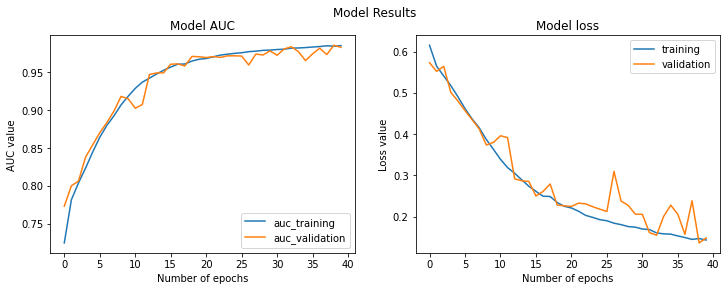

In [66]:
plt_function_op(history)

## Thoughts and observation for trial 7:
This gave a score on Kaggle = 0.83483.

I thought this trial will be good enough as now I made the balanced and each class has the same weight in the contribution in the model. Besides, I used the aggregation method =  RGAT, which gave me a good results before the upsampling but its results were less than by the GGNN aggregation method. I also increased the number of the units in the embedding layer to 500, so all of that I thought the results will be good and the model will learn well from the features. I tried to control the overfitting on the training data by validate the model. I used a batch size not small and this helps also in preventing the overfitting.
So, by training the model I reached auc on the validation set = 0.9828, and the resultant auc on Kaggel is 0.83483. So, this means they are close to each other, and there is no overfitting or underfitting in the model. Besides, from the above graphs we can see that there is no overfitting but the results are good enough. So, the upsampling for the data has a very good effect on the results with the using of the aggregation method = RGAT. Besides, increasing the number of the units in the embedding layer helped the model. And from the graphs we can see that the auc curve started to be a little bit smooth in the validation and the training, and the oscillations in the loss were decreased. And there is big differences between the validation, and the training so there is no overfitting.


## Plan for the trial 8:
I will continue with the same preprocessing way on the upsampling data. But I will make some changes in the model. By applying an aggregation method = 'RGCN' in the parameters of the GNN input layer. 

Which helps in solving those two fundamental tasks: Entity classification - Where you assign types and categorical properties to entities, and Link prediction - Where you recover missing triples.
AS it is using a common graph convolutional network. It’s extended with multi-edge encoding to compute embedding of the entities, but with different downstream processing. So, Entity classification is done by attaching a softmax classifier at the final embedding of an entity (node). Training is through loss of standard cross-entropy, and Link prediction is done by reconstructing an edge with an autoencoder architecture, using a parameterized score function. Training uses negative sampling.

So, I can see the effect of the upsampling data with the RGCN aggregation method.

# Trial 8
With upsampling data + RGCN aggregation method + 500 dimensional space in embedded layer, and 128 unit in the hidden dimentional in the GNN input layer.


In [67]:
# prepare input units for each input we have for the neural network
data = keras.Input(batch_shape=(None,))
# the first dim is different to the previous one, it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
# insert the embedding layer with embedding space of 20 dimensions that will be applied on our data after victorized it
embeded = Embedding(tokenizer.num_words, 500)(data)

# number of graphs (number of samples), and add 1 as python is zero based 
num_graph = tf.reduce_max(node2graph)+1

# prepare the Graph Neural Network input layer by give it its inputs
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# get the parameters that are required to be used with the Graph Neural Network input layer so we can get the output
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
# change the number of the size of the output of all message passing layers to 128 layer
params["hidden_dim"] = 128
# define the aggregation method
params["message_calculation_class"] = "RGCN"
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

# get the mean of each sample in each batch by using the segment_mean as each sample is a segment in the array
# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

# prepare the output node for our problem with 1 unit which gives 0 or 1 as we are making binary classification
pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)

# define our model and give it the inputs layers and the outputs layers
model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
# view the model with its parameters and shapes of the layers
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='gnn_7/StatefulPartitionedCall:0', description="created by layer 'gnn_7'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='tf.math.segment_mean_7/SegmentMean:0', description="created by layer 'tf.math.segment_mean_7'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_7/Sigmoid:0', description="created by layer 'dense_7'")
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_22 (InputLayer)          [(None,)]            0           []      

In [68]:
# compile the model with BinaryCrossentropy loss as we are making binary classification, and AUC metric
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [69]:
# define the size of the batch
batch_size = 128
# get the number of the batches in the training and validation by splitting the size of the training data or validation data
# by the size required for the batch
num_batchs = math.ceil(len(training_set_up) / batch_size)
num_batchs_validation = math.ceil(len(validation_set_up) / batch_size)

# fit the model on the training data and validation data by generating the bathes for the training and validation
history = model.fit(
    gen_batch(
        training_set_up, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=40,
    validation_data=gen_batch(
        validation_set_up, batch_size=128, repeat=True
    ),
    validation_steps=num_batchs_validation,
)


Epoch 1/40
317/317 [==============================] - 19s 51ms/step - loss: 0.6270 - auc: 0.7060 - val_loss: 0.5873 - val_auc: 0.7538
Epoch 2/40
317/317 [==============================] - 15s 49ms/step - loss: 0.5893 - auc: 0.7545 - val_loss: 0.6468 - val_auc: 0.6998
Epoch 3/40
317/317 [==============================] - 16s 50ms/step - loss: 0.5712 - auc: 0.7739 - val_loss: 0.5844 - val_auc: 0.7808
Epoch 4/40
317/317 [==============================] - 15s 49ms/step - loss: 0.5460 - auc: 0.7997 - val_loss: 0.5386 - val_auc: 0.8124
Epoch 5/40
317/317 [==============================] - 15s 49ms/step - loss: 0.5224 - auc: 0.8192 - val_loss: 0.5438 - val_auc: 0.8196
Epoch 6/40
317/317 [==============================] - 16s 49ms/step - loss: 0.5004 - auc: 0.8377 - val_loss: 0.5213 - val_auc: 0.8379
Epoch 7/40
317/317 [==============================] - 16s 49ms/step - loss: 0.4823 - auc: 0.8505 - val_loss: 0.5141 - val_auc: 0.8490
Epoch 8/40
317/317 [==============================] - 16s 49ms

In [70]:
# predict the outputs also by generating the batch by the given size
y_pred = model.predict(
    gen_batch(testing_set, batch_size=128, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

In [71]:
# save the predictions in a csv file to submit it on Kaggle
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('try 8.csv')

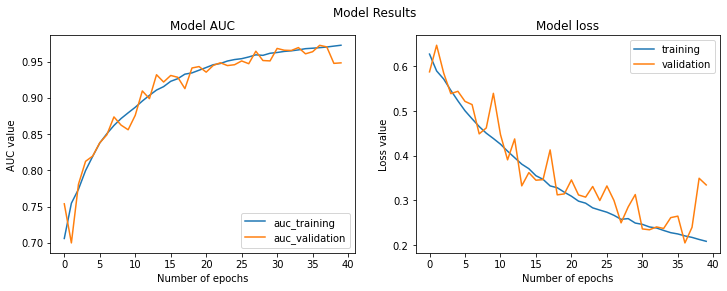

In [72]:
plt_function_op(history)

## Thoughts and observation for trial 8:
This gave a score on Kaggle = 0.76893.

I thought this trial will be better than trial number 2 as now I made the balanced and each class has the same weight in the contribution in the model. So I thought that the unsampling will be better with the RGCN aggregation method. I also increased the number of the units in the embedding layer to 500, so all of that I thought the results will be good and the model will learn well from the features. But the results are not good. I tried to control the overfitting on the training data by validate the model. I used a batch size not small and this helps also in preventing the overfitting. But from the results, I think the model is overfitting the training data. 
As by training the model I reached auc on the validation set = 0.9482, and the resultant auc on Kaggel is 0.76893. So, the upsampling for the data has a very good effect on the results with the using of the aggregation method = RGCN. Besides, increasing the number of the units in the embedding layer helped the model better than without the upsampling. But from the above graphs we can see that there is no overfitting untill epoch almost 36, and the results on Kaggle are not good enough as I expected from this trial.


## Plan for the trial 9:
With continue working on the upsampled data with the same preprocessing way.
In the model, I will try another aggregation method:

RGIN: Relational Graph Isomorphism Networks.

# Trial 9
With upsampled data + RGIN aggregation method + 500 dimensional space in embedded layer, and 128 unit in the hidden dimentional in the GNN input layer.

In [73]:
# prepare input units for each input we have for the neural network
data = keras.Input(batch_shape=(None,))
# the first dim is different to the previous one, it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
# insert the embedding layer with embedding space of 20 dimensions that will be applied on our data after victorized it
embeded = Embedding(tokenizer.num_words, 500)(data)

# number of graphs (number of samples), and add 1 as python is zero based 
num_graph = tf.reduce_max(node2graph)+1

# prepare the Graph Neural Network input layer by give it its inputs
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# get the parameters that are required to be used with the Graph Neural Network input layer so we can get the output
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
# change the number of the size of the output of all message passing layers to 128 layer
params["hidden_dim"] = 128
# define the aggregation method
params["message_calculation_class"] = "RGIN"
params['num_aggr_MLP_hidden_layers'] = 4
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

# get the mean of each sample in each batch by using the segment_mean as each sample is a segment in the array
# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

# prepare the output node for our problem with 1 unit which gives 0 or 1 as we are making binary classification
pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)

# define our model and give it the inputs layers and the outputs layers
model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
# view the model with its parameters and shapes of the layers
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='gnn_8/StatefulPartitionedCall:0', description="created by layer 'gnn_8'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='tf.math.segment_mean_8/SegmentMean:0', description="created by layer 'tf.math.segment_mean_8'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_8/Sigmoid:0', description="created by layer 'dense_8'")
Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_25 (InputLayer)          [(None,)]            0           []      

In [74]:
# compile the model with BinaryCrossentropy loss as we are making binary classification, and AUC metric
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [75]:
# define the size of the batch
batch_size = 128
# get the number of the batches in the training and validation by splitting the size of the training data or validation data
# by the size required for the batch
num_batchs = math.ceil(len(training_set_up) / batch_size)
num_batchs_validation = math.ceil(len(validation_set_up) / batch_size)

# fit the model on the training data and validation data by generating the bathes for the training and validation
history = model.fit(
    gen_batch(
        training_set_up, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=40,
    validation_data=gen_batch(
        validation_set_up, batch_size=128, repeat=True
    ),
    validation_steps=num_batchs_validation,
)


Epoch 1/40
317/317 [==============================] - 30s 81ms/step - loss: 0.6494 - auc: 0.6799 - val_loss: 0.6072 - val_auc: 0.7452
Epoch 2/40
317/317 [==============================] - 25s 78ms/step - loss: 0.6183 - auc: 0.7238 - val_loss: 0.6494 - val_auc: 0.7359
Epoch 3/40
317/317 [==============================] - 25s 79ms/step - loss: 0.5967 - auc: 0.7514 - val_loss: 0.6695 - val_auc: 0.7560
Epoch 4/40
317/317 [==============================] - 25s 79ms/step - loss: 0.5828 - auc: 0.7690 - val_loss: 0.5597 - val_auc: 0.7997
Epoch 5/40
317/317 [==============================] - 25s 79ms/step - loss: 0.5732 - auc: 0.7771 - val_loss: 0.5866 - val_auc: 0.7939
Epoch 6/40
317/317 [==============================] - 25s 78ms/step - loss: 0.5768 - auc: 0.7794 - val_loss: 0.5687 - val_auc: 0.7795
Epoch 7/40
317/317 [==============================] - 25s 79ms/step - loss: 0.5731 - auc: 0.7783 - val_loss: 0.5991 - val_auc: 0.7704
Epoch 8/40
317/317 [==============================] - 25s 79ms

In [76]:
# predict the outputs also by generating the batch by the given size
y_pred = model.predict(
    gen_batch(testing_set, batch_size=128, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

In [77]:
# save the predictions in a csv file to submit it on Kaggle
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('try 9.csv')

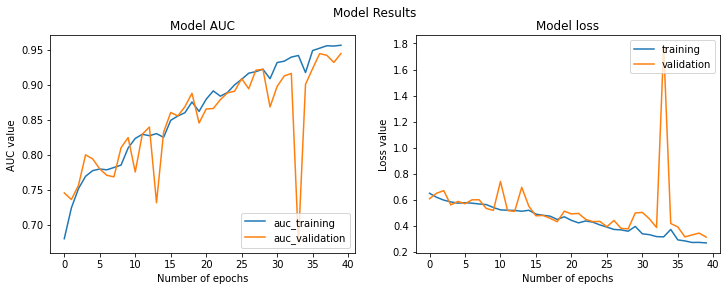

In [78]:
plt_function_op(history)

## Thoughts and observation for trial 9:
This gave a score on Kaggle = 0.83796.

My expectations for this trial weren't good as the aggregation method I used I didn't thought that it will be good with our dataset. Although I worked on the upsampled data and now I made the balanced and each class has the same weight in the contribution in the model., the results weren't good. I also increased the number of the units in the embedding layer to 500, so by this I thought the results will be good and the model will learn well from the features. But the results are not good. I tried to control the overfitting on the training data by validate the model. I used a batch size not small and this helps also in preventing the overfitting. But from the results, I think the model is underfitting the training data, and didn't learn well from the input features. As by training the model I reached auc on the validation set = 0.9445, and the resultant auc on Kaggel is 0.83796. So, the upsampling for the data has a very good effect on the results but with the using of the aggregation method = RGIN, it didn't work well with the model. From the graphs we can see that there are big oscillations and the model didn't learn well from the data as its results are less than other trials, so I think the model is underfitting in this trial.



## Plan for the trial 10:
### Preprocessing:
I will change the preprocessing and I will use max_vocab = 1000 so the model works on the most 1000 frequent nodes that appear in the dataset. With using max_len = 30, so the model will work on length = 30, so all samples will be with length = 30. So, if the sample contains less than 30, it will padded with adding zeros untill it reaches length = 30 with padding method = 'post', so zeros will be added after the last element in the sample. If the sample contains more than 30, it will be truncated with the default value = 'pre' so it will remove from the beginning of the sample untill the sample reach length = 30.

Then, as we are dealing with text, I will make tokenization for the input to split it into characters. So, we can fit the tokenization on the input then apply the rest of the steps that we talked about from padding, and truncating.

Then to deal with our data, we can't split it into batches as we did in the previous assignments. But here we need to generate each batch that the model will work on. I will talk about this part again down.


### Model:
In the model, I will try in this trial the following:

One embedded layer with dimensional space of 500 dimensions that will be applied on our data after victorized it, and in the hidden dimentional in the GNN input layer, I will use 256 unit in it. I will make this with fitting the model and get the features from the upsampled data.


# Trial 10
Max_vocab = 1000 but in the previous trails I used it by 500, so I can find the effect of it with the upsampled data.

### Preprocessing for trial 10:

In [79]:
# define the max_vocab and max_len parameters
max_vocab = 1000
max_len = 30

# build vocabulary from training set and make tokenization on the input
all_nodes = [s[0] for s in training_set]
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(all_nodes)
# I will use random.seed(0) to generate each time I run this code the same random numbers if needed
random.seed(0)

# to prepare the samples in each batch 
def prepare_single_batch(samples):
    # get the number of the samples required for each batch
    sample_nodes = [s[0] for s in samples]
    # make victorization for the samples by by turning each text into either a sequence of integers 
    #(each integer being the index of a token in a dictionary) 
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes)
    # prepare the victorized array by making padding by post method
    sample_nodes = pad_sequences(sample_nodes, padding='post')
    # get the number of nodes in each sample
    max_nodes_len = np.shape(sample_nodes)[1]
    # here we need to organize the edges by making the edges in each sample to start from the end of the previous 
    # batch not from zero
    edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)]
    # check that aall edges not zeros
    edges = [e for e in edges if len(e) > 0]
    # convert the graphs of each sample from the sample's nodes by making the graphs in each sample to start from the 
    # end of the previous batch not from zero
    node_to_graph = [[i]*max_nodes_len for i in range(len(samples))]
    # convert the shape of the sample nodes into array by making each sample's sample_nodes into columns in one row, 
    # and the rows refer to the samples
    all_nodes = np.reshape(sample_nodes, -1)
    # make concatenation for the arrays of edgesin all samples in the batch
    all_edges = np.concatenate(edges)
    
    # reshape the node_to_graph to array by making each sample's node_to_graph into columns in one row, and the rows refer to 
    # the samples
    node_to_graph = np.reshape(node_to_graph, -1)
    return {
        'data': all_nodes,
        'edges': all_edges,
        'node2grah': node_to_graph,
    }, np.array([s[2] for s in samples])



# function to geerate the batches required by splitting the given data into batches and each batch is prepared by the 
# prepare_single_batch function
def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True):
    while True:
        dataset = list(dataset)
        if shuffle:
            random.shuffle(dataset)
        l = len(dataset)
        for ndx in range(0, l, batch_size):
            batch_samples = dataset[ndx:min(ndx + batch_size, l)]
            yield prepare_single_batch(batch_samples)
        if not repeat:
            break

### Model for trial 10:


In [80]:
# prepare input units for each input we have for the neural network
data = keras.Input(batch_shape=(None,))
# the first dim is different to the previous one, it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
# insert the embedding layer with embedding space of 20 dimensions that will be applied on our data after victorized it
embeded = Embedding(tokenizer.num_words, 500)(data)

# number of graphs (number of samples), and add 1 as python is zero based 
num_graph = tf.reduce_max(node2graph)+1

# prepare the Graph Neural Network input layer by give it its inputs
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# get the parameters that are required to be used with the Graph Neural Network input layer so we can get the output
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
# change the number of the size of the output of all message passing layers to 256 layer
params["hidden_dim"] = 256
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

# get the mean of each sample in each batch by using the segment_mean as each sample is a segment in the array
# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

# prepare the output node for our problem with 1 unit which gives 0 or 1 as we are making binary classification
pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)

# define our model and give it the inputs layers and the outputs layers
model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
# view the model with its parameters and shapes of the layers
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 256), dtype=tf.float32, name=None), name='gnn_9/StatefulPartitionedCall:0', description="created by layer 'gnn_9'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 256), dtype=tf.float32, name=None), name='tf.math.segment_mean_9/SegmentMean:0', description="created by layer 'tf.math.segment_mean_9'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_9/Sigmoid:0', description="created by layer 'dense_9'")
Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_30 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_28 (InputLayer)          [(None,)]            0           []      

In [81]:
# compile the model with BinaryCrossentropy loss as we are making binary classification, and AUC metric
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [82]:
# define the size of the batch
batch_size = 128
# get the number of the batches in the training and validation by splitting the size of the training data or validation data
# by the size required for the batch
num_batchs = math.ceil(len(training_set_up) / batch_size)
num_batchs_validation = math.ceil(len(validation_set_up) / batch_size)

# fit the model on the training data and validation data by generating the bathes for the training and validation
history = model.fit(
    gen_batch(
        training_set_up, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=40,
    validation_data=gen_batch(
        validation_set_up, batch_size=128, repeat=True
    ),
    validation_steps=num_batchs_validation,
)


Epoch 1/40
317/317 [==============================] - 31s 90ms/step - loss: 0.6209 - auc: 0.7163 - val_loss: 0.5833 - val_auc: 0.7637
Epoch 2/40
317/317 [==============================] - 28s 89ms/step - loss: 0.5779 - auc: 0.7662 - val_loss: 0.5741 - val_auc: 0.7778
Epoch 3/40
317/317 [==============================] - 28s 89ms/step - loss: 0.5501 - auc: 0.7955 - val_loss: 0.6119 - val_auc: 0.7884
Epoch 4/40
317/317 [==============================] - 28s 89ms/step - loss: 0.5129 - auc: 0.8275 - val_loss: 0.5049 - val_auc: 0.8374
Epoch 5/40
317/317 [==============================] - 28s 88ms/step - loss: 0.4782 - auc: 0.8531 - val_loss: 0.4784 - val_auc: 0.8544
Epoch 6/40
317/317 [==============================] - 28s 89ms/step - loss: 0.4490 - auc: 0.8719 - val_loss: 0.4328 - val_auc: 0.8841
Epoch 7/40
317/317 [==============================] - 28s 89ms/step - loss: 0.4226 - auc: 0.8874 - val_loss: 0.4477 - val_auc: 0.8791
Epoch 8/40
317/317 [==============================] - 28s 90ms

In [83]:
# predict the outputs also by generating the batch by the given size
y_pred = model.predict(
    gen_batch(testing_set, batch_size=128, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

In [84]:
# save the predictions in a csv file to submit it on Kaggle
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('try 10.csv')

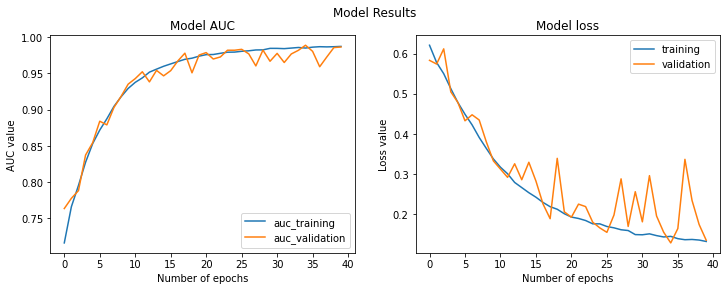

In [85]:
plt_function_op(history)

## Thoughts and observation for trial 10:
This gave a score on Kaggle = 0.81728.

My expectations were by changing the max_vocab and increase it so the model will learn from larger data amount. This would be better and give a better results than any trial else. But this didn't work as I thought. As I found that the model is overfitting the training dataset, and didn't work well on the unseen dataset. Besides, working on the upsampled data but the max_vocab affected the model negatively.
Although the number of the units in the embedding layer were large, the results aren't good. And, although the construction of the model is good, the results aren't good. 
So, by training the model I reached auc on the validation set = 0.9864, and the resultant auc on Kaggel is 0.81728. So, this means they aren't close to each other, and there is overfitting in the model. Besides, from the above graphs we can see that there is overfitting as the oscillations in the loss have big amplitudes so the results and the effect of increasing the max_vocab wasn't good with this trial eventhough I used the upsampled data.


# Overall findings and observations:
- Making the data balanced are very important for the neural networks, as after I made upsampling for the class that has label 1 the results had been better than the models that were trained on the unbalanced data. Besides, the unbalanced data made the model have many oscillations in the loss, and the auc curves. Those oscillations have a high amplitudes, and models that were trained on the unbalanced data didn't work well on the unseen data (test dataset).

- There are some aggregation methods helped the models to be better, and work well on the unseen data like the GGNN, and RGAT. Their mechanisms in working were very suitable with the data after finishing the preprocessing on it.

- In dealing with the graphical data like I had in this time, the increasing of the max_vocab wasn't a good solution as it increased the complexity of the model with no benefits. So, this took more time on the training but the model didn't work well on the unseen dataset.


-------------------------------------------------------------------------------------------------------------------------------

# Questions 

## Based on the provided template, describe the format of the input file (sdf file).
* The input file is Structure Data file or Structure Data Format, it is a chemical file format. It is used to describe multiple chemical compounds with a certain shape. It was developed and published by Molecular Design Limited (MDL) and became the the most widely used standard for importing and exporting information on chemicals. In the file each different compound is separated by `$$$$` expression. In each compound, it consists from some letter which refer to the nodes names that format this compound. And some numbers that refer to the edges or the links between the nodes that help in knowing which node is connected to which node. And other numbers that refer to the weight of each link, and data about that chemical compound like Melting Point, Record No., ID, and more.



## What are the input tensors to the neural network model (their meaning, not just symbol)? What is each of their dims and their meaning (e.g. batch_size)?
* The input tensors to the neural network model are three:
    * Data: it is the input tensor that contains the nodes names that we got from the sdf files after making tokenization for them, and convert them into numerical representation after finishing the preprocessing on it, and make padding and truncating to make the samples with the same length. It has dimension by [batch_size*max_nodes_len], where the batch_size is the number of samples in each batch and max_nodes_len is the length of tokenized nodes after making preprocessing and padding on them.
    
    * Node_2_graph: it is the input tensor that contains information about the segments and the segments ids, as we start each segment in it from the end of the previous segment in it. It has dimension by [batch_size*max_nodes_len], where the batch_size is the number of samples in each batch and max_nodes_len is the length of tokenized nodes after making preprocessing and padding on them.
    
    * edges: it is the input tensor that contains the links between the nodes in the compounds, so for each row in the array it has two numbers for each link which the first number refers to the number of the node which the links will start from, and the second number refers to the number of the node which the links will end at. It has dimension by [sum_of_all_edges,2], where um_of_all_edges represents the sum (number of edges in each sample) of the batch_size. For example if a batch contains 4 samples, and the number of edges in sample 1: 10, in sample 2: 25, in sample 3: 15, and in sample 4: 30. So the size of the edge tensor will be [80,2].



## For each dim of gnn_out, what does it symbolize? For each dim of avg, what does it symbolize?
* gnn_out: it contains the output of the aggregation of each hidden layer in the GNN layers in the model. It has dimension by [batch_size_node_dimension, hidden layers number], where batch_size_node_dimension is the dimension of the input data after the tokenization for the whole batch for the node vector, and the number of the hidden_dim is the GNN layers.

* avg: it contains the mean for each segment of the gnn_out depend on the segments ids that is taken from the node2graph that we talked about before. It contains the information about each sample and saves it after getting the mean for each segment in the batch size. It has dimension [batch_size, hidden_layer], as the dimension of the gnn_out is [batch_size_node_dimension, hidden layers number], and the avg takes the segment mean and each sample has one segment id. So, it represents each sample with one number for each hidden layer. 



## What is the difference between segment_mean and tf.reduce_mean? For each dim of pred, what does it symbolize?
* segment_mean gives the mean for each segment in the array, according to the segment id. As shown in the following image:
![image.png](https://www.tensorflow.org/images/SegmentMean.png)

* tf.reduce_mean gives the mean of elements across dimensions of a tensor, it reduces the input across the dimensions given in axis by getting the mean of the elements across the dimensions in that axis. 

* dim of pred means the dimension of the predictions is [batch_size, 1], and it means the probability of the test chemical compound for each sample whether it has effect on the cancer or not. It is numerical value refers to the probability of the activity on the cancer for each sample.



## What is the motivation/theory/idea to use multiple gcn layers comparing to just one? How many layers were used in the template?
* The motivation in using multiple Graph Convolution Network is to increase the complexity of the model, so the model will learn more from the input features. So, this helps in predict the right predictions for the test data. As using multiple gcn helps in combining all the graph complexity properly.
* In the template, the number of the layers were the default value which is "num_layers": 4.

# References
1. https://rb.gy/vqnyle
2. https://rb.gy/slnucq
3. https://rb.gy/ns6fmv
4. https://rb.gy/izh5mh

